# Exploratory Data Analysis

## Introduction

The CheXpert (Chest eXpert) is a large publicly available dataset, consisting of 224,316 chest radiographs from 65,240 patients. Each radiograph is labeled for the presence of 14 distinct observations, categorized as positive, negative, or uncertain. 

These observations include:
1. **No Finding:** Captures the absence of all pathologies.
2. **Enlarged Cardiom.**
3. **Cardiomegaly**
4. **Lung Lesion**
5. **Lung Opacity**
6. **Edema**
7. **Consolidation**
8. **Pneumonia:** Denotes the images that suggest primary infection.
9. **Atelectasis**
10. **Pneumothorax**
11. **Pleural Effusion**
12. **Pleural Other**
13. **Fracture**
14. **Support Devices:** Indicates the presence of medical devices.


First, mentions of specific observations are extracted from the radiology reports. This step identifies the presence or suggestion of various conditions and findings within the images.

Following the extraction, these mentions are classified into three distinct categories: negative, uncertain, and positive. 
A mention is classified as **negative** when the report explicitly indicates the absence of conditions (e.g., "no evidence of pulmonary edema, pleural effusions, or pneumothorax"). **Uncertain** if the report suggests a possible condition with ambiguity or doubt (e.g., "diffuse reticular pattern may represent mild interstitial pulmonary edema"), encapsulating both the radiologist's uncertainty and the inherent vagueness of the report (e.g., "heart size is stable"). A **positive** classification is applied to mentions that definitively indicate the presence of conditions (e.g., "moderate bilateral effusions and bibasilar opacities").

This classification framework is then applied to determine the final label for each of the 14 observations, which includes 12 specific pathologies along with "Support Devices" and "No Finding." An observation receives a **positive (1)** label if it is mentioned in a manner classified as positive at least once within the report. It is labeled **uncertain (u)** if there are one or more uncertain mentions without any positive mentions. A **negative** label is assigned in the presence of at least one negatively classified mention. If an observation is not mentioned at all, it is marked as **blank**.

## Intial setup

### Required libraries

In [9]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread

### CheXpert dataset

In [4]:
# Loading the csv files
train_data = pd.read_csv("../../../data_shares/purrlab/CheXpert/CheXpert-v1.0-small/train.csv", index_col=0)
val_data = pd.read_csv("../../../data_shares/purrlab/CheXpert/CheXpert-v1.0-small/valid.csv", index_col=0)
#test_data = pd.read_csv("../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test_labels.csv", index_col=0)


# Appending the files to have the whole dataset
data = pd.concat([train_data, val_data])#, #test_data])

In [119]:
# Adjusting the headers column and printing the data
data.reset_index()
display(data)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68.0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87.0,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83.0,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83.0,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41.0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224311,test/patient65236/study1/view1_frontal.jpg,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224312,test/patient65237/study1/view1_frontal.jpg,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224313,test/patient65238/study1/view1_frontal.jpg,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224314,test/patient65239/study1/view1_frontal.jpg,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## The shape of the data

In [4]:
num_observations, num_features = data.shape

print("The size of the data:")
print(f"\t - The number of observations (rows) is {num_observations}.")
print(f"\t - The number of features (columns) is {num_features}.")

The size of the data:
	 - The number of observations (rows) is 224316.
	 - The number of features (columns) is 18.


In [5]:
print("The type of the data:\n")
print(data.dtypes)

The type of the data:

Sex                            object
Age                           float64
Frontal/Lateral                object
AP/PA                          object
No Finding                    float64
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
dtype: object


In [6]:
print("Checking for the number of missing values:\n")
print(data.isnull().sum())

Checking for the number of missing values:

Sex                              668
Age                              668
Frontal/Lateral                  668
AP/PA                          33087
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64


#### NOTE: we need to handle the missing values by replacing them with 0?? or maybe droping the rows?


## Summary of the data

In [94]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])

print("Analysis of the numerical variables:")
display(numerical_data.describe().round(2))

Analysis of the numerical variables:


,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223648.00,23283.00,45741.00,47105.00,118680.00,12846.00,86858.00,71524.00,28510.00,69345.00,79836.00,134113.00,7394.00,13096.00,124119.00
mean,60.43,0.97,-0.03,0.41,0.85,0.60,0.45,-0.18,-0.45,-0.00,0.20,0.56,0.12,0.64,0.93
std,17.82,0.18,0.72,0.76,0.47,0.69,0.74,0.75,0.82,0.99,0.49,0.65,0.91,0.57,0.29
min,0.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,49.00,1.00,-1.00,0.00,1.00,0.00,0.00,-1.00,-1.00,-1.00,0.00,0.00,-1.00,0.00,1.00
50%,62.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,-1.00,0.00,0.00,1.00,0.00,1.00,1.00
75%,74.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00
max,90.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


NOTE: age 0

In [ ]:
print("Skewness of the numerical variables:\n")
print(numerical_data.skew())

In [ ]:
print("Kurtosis of the numerical variables:\n")
print(numerical_data.kurtosis())

In [10]:
pathologies = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

report_data = []

for pathology in pathologies:
    total = len(data[pathology])
    positive = (data[pathology] == 1).sum()
    uncertain = (data[pathology] == -1).sum()
    negative = (data[pathology] == 0).sum()
    nan_values = data[pathology].isna().sum()
    
    positive_pct = (positive / total) * 100
    uncertain_pct = (uncertain / total) * 100
    negative_pct = (negative / total) * 100
    nan_pct = (nan_values / total) * 100
    
    report_data.append([pathology, f"{positive} ({positive_pct:.2f}%)", f"{uncertain} ({uncertain_pct:.2f}%)", f"{negative} ({negative_pct:.2f}%)", f"{nan_values} ({nan_pct:.2f}%)"])

report_df = pd.DataFrame(report_data, columns=["Pathology", "Positive (%)", "Uncertain (%)", "Negative (%)", "NaN (%)"], index=range(1, len(pathologies) + 1))

print("Summary of the 14 labeled observations:")
display(report_df)

Summary of the 14 labeled observations:


,Pathology,Positive (%),Uncertain (%),Negative (%),NaN (%)
1,No Finding,22528 (10.04%),0 (0.00%),755 (0.34%),201033 (89.62%)
2,Enlarged Cardiomediastinum,11205 (5.00%),12403 (5.53%),22133 (9.87%),178575 (79.61%)
3,Cardiomegaly,27243 (12.14%),8087 (3.61%),11775 (5.25%),177211 (79.00%)
4,Lung Lesion,9201 (4.10%),1488 (0.66%),2157 (0.96%),211470 (94.27%)
5,Lung Opacity,106017 (47.26%),5598 (2.50%),7065 (3.15%),105636 (47.09%)
6,Edema,52376 (23.35%),12984 (5.79%),21498 (9.58%),137458 (61.28%)
7,Consolidation,14851 (6.62%),27742 (12.37%),28931 (12.90%),152792 (68.11%)
8,Pneumonia,6061 (2.70%),18770 (8.37%),3679 (1.64%),195806 (87.29%)
9,Atelectasis,33634 (14.99%),33739 (15.04%),1972 (0.88%),154971 (69.09%)
10,Pneumothorax,19466 (8.68%),3145 (1.40%),57225 (25.51%),144480 (64.41%)


## Individual variables

### Overview

Histogram and boxplot for numerical variables:


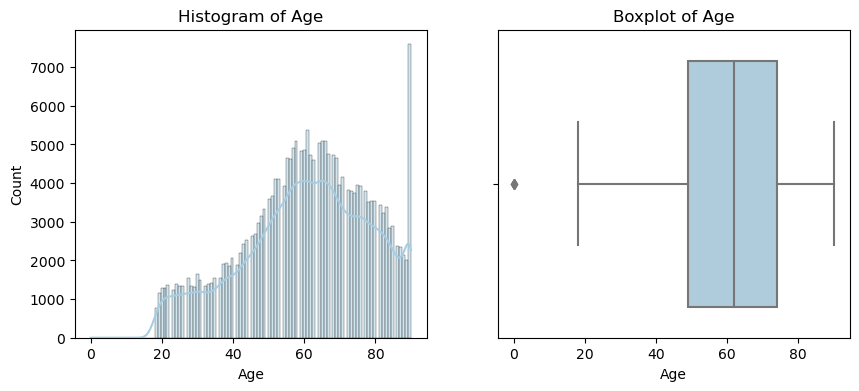

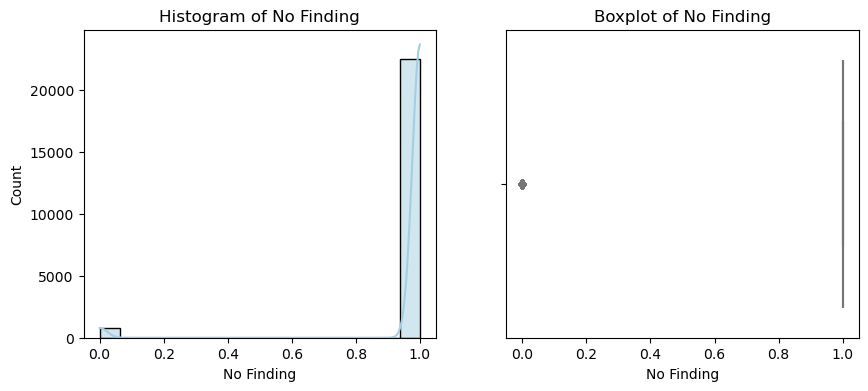

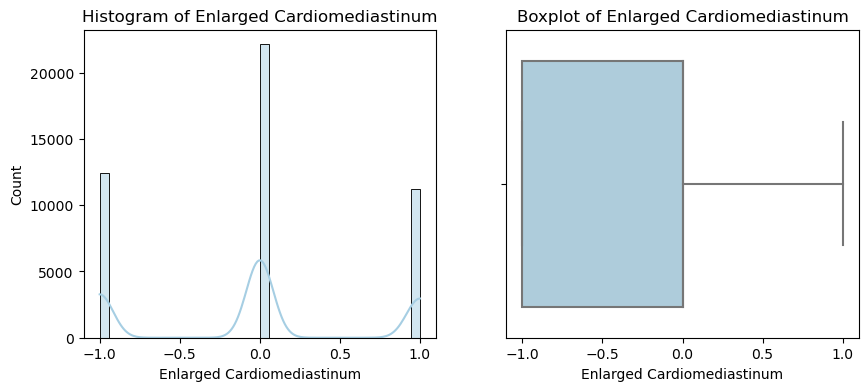

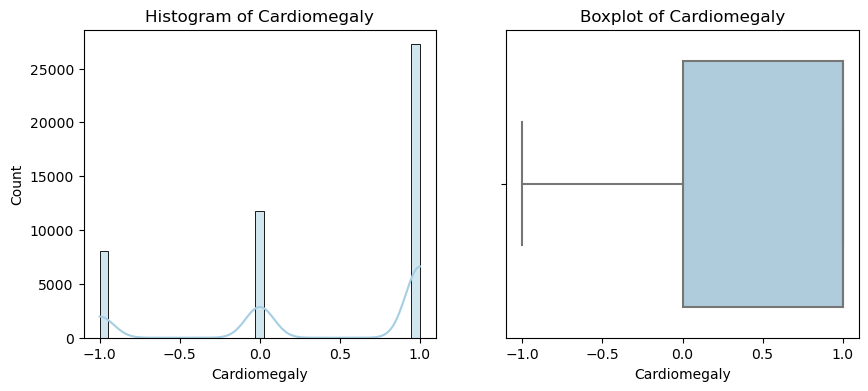

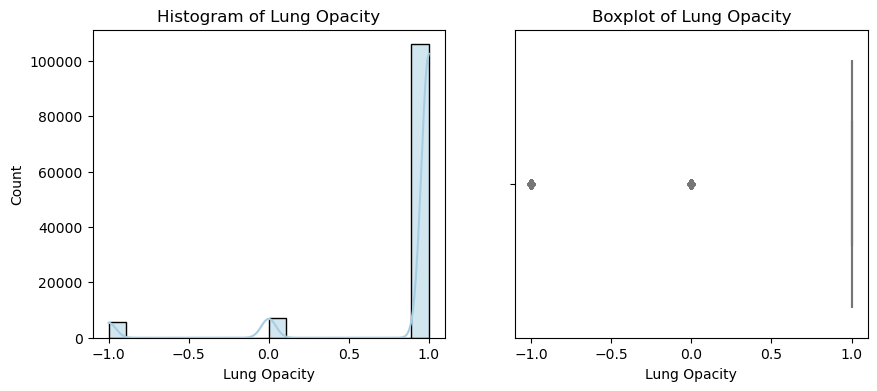

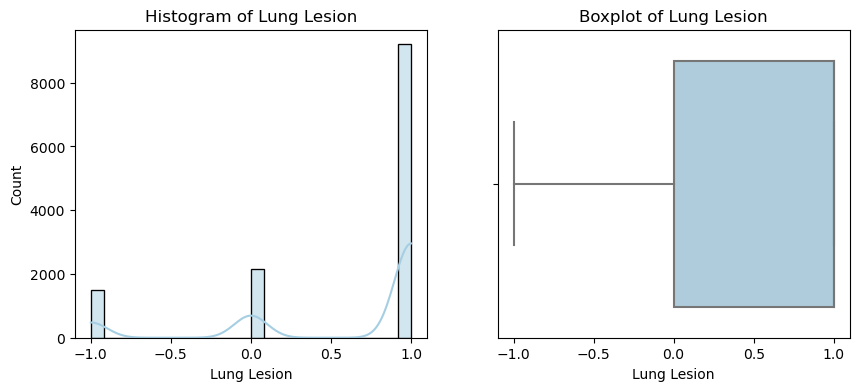

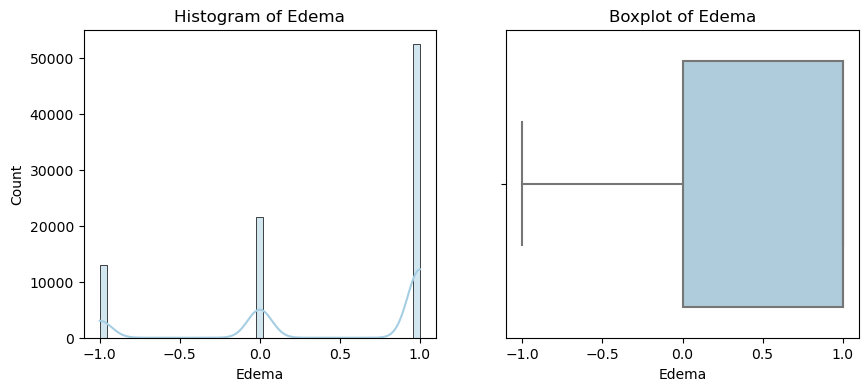

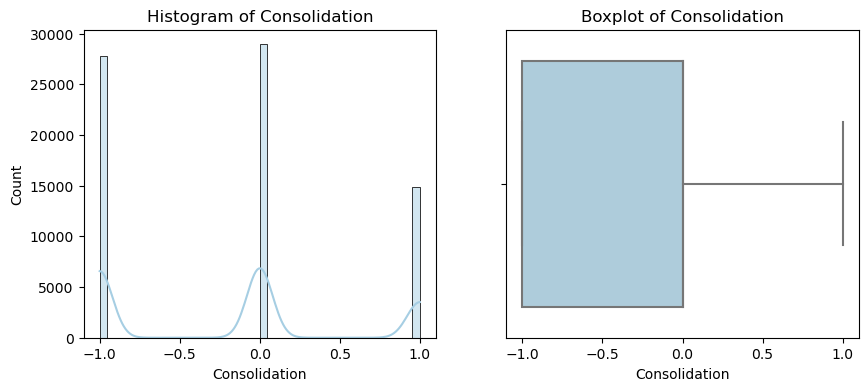

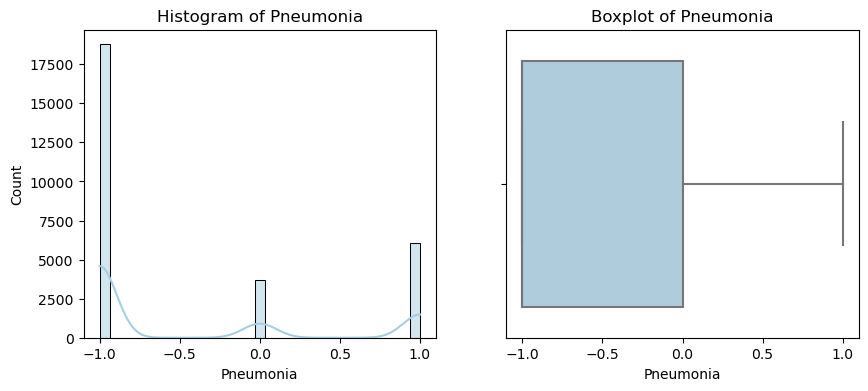

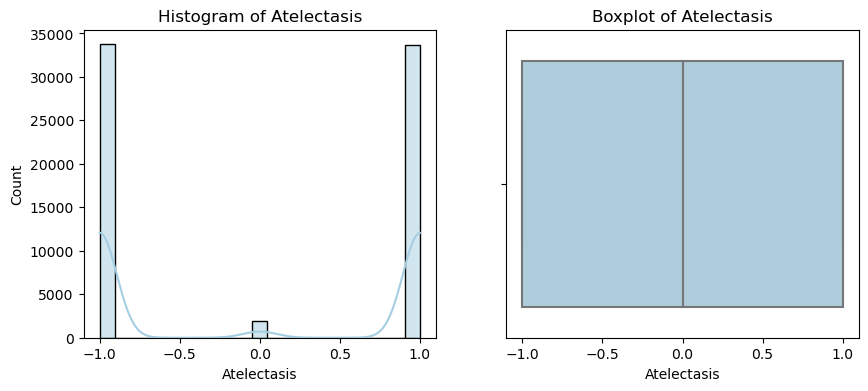

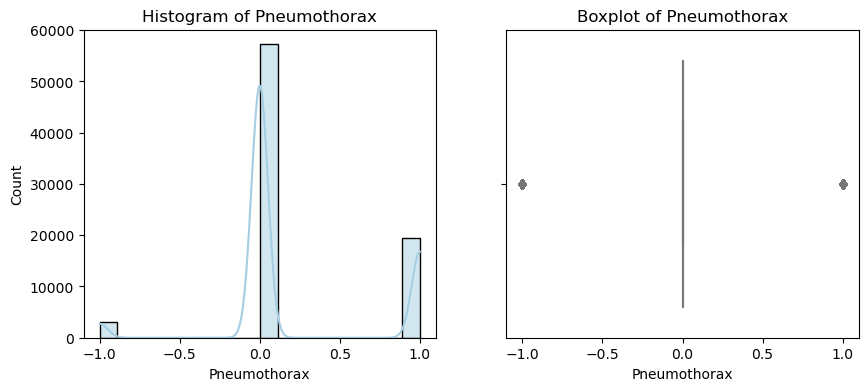

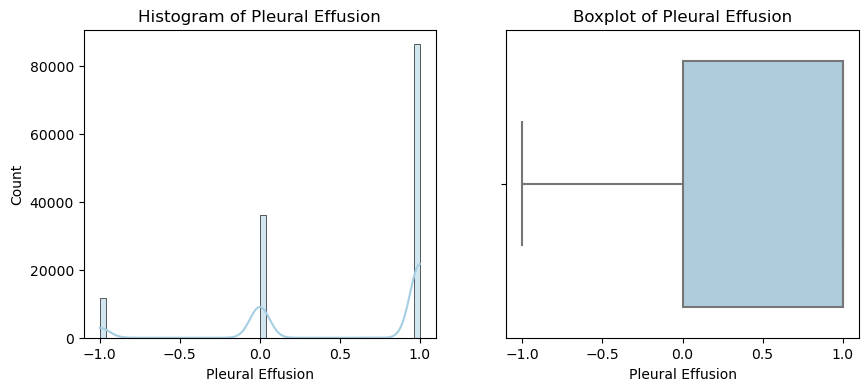

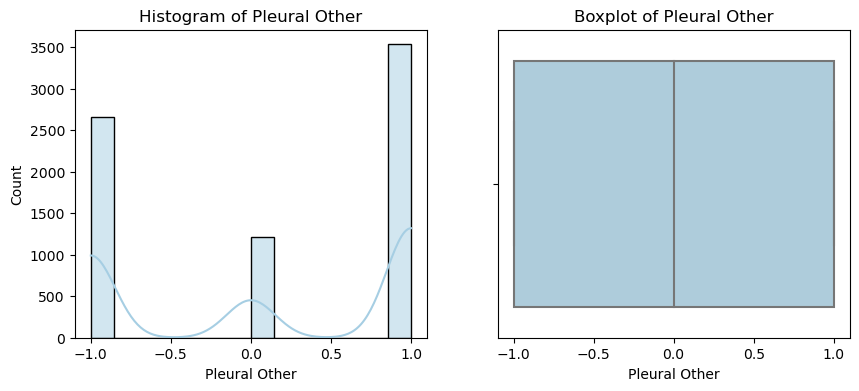

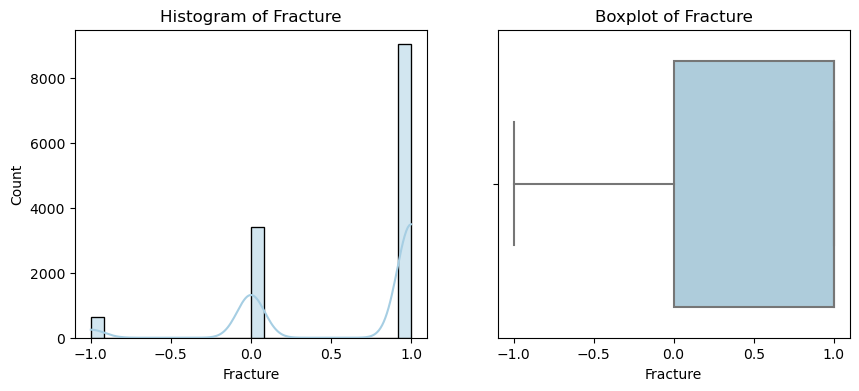

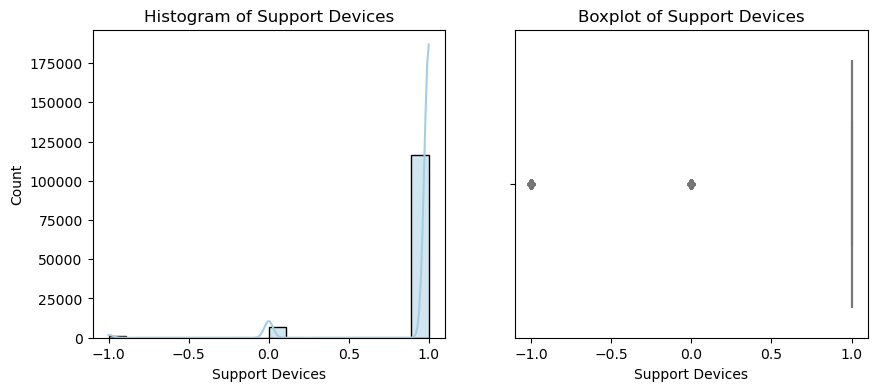

In [21]:
print("Histogram and boxplot for numerical variables:")

palette = sns.color_palette("pastel")
sns.set_palette("Paired")

for column in numerical_data.columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(numerical_data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=numerical_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Barchart for categorical variables:


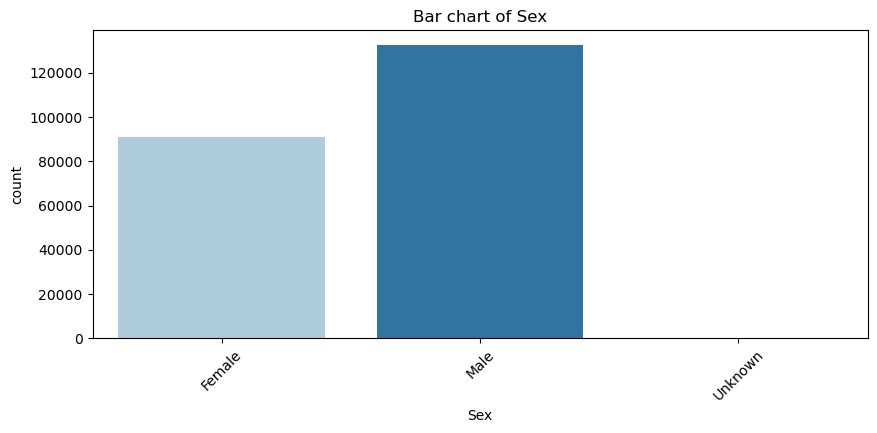

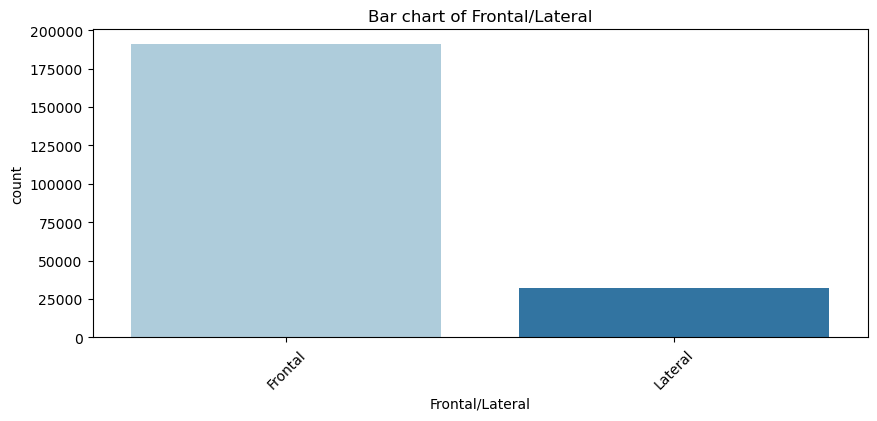

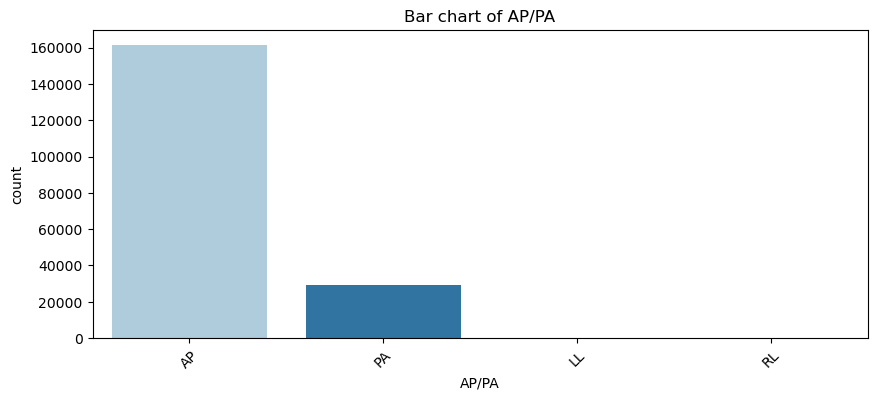

In [22]:
print("Barchart for categorical variables:")

categorical_data = train_data.select_dtypes(include=['object'])
for column in categorical_data.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=categorical_data[column])
    plt.title(f'Bar chart of {column}')
    plt.xticks(rotation=45)
    plt.show()

### In depth: 'Sex' and 'Age'

In [124]:
data['PatientID'] = data['Path'].str.extract('(patient\d+)/')
data_by_patient = data.groupby('PatientID').agg({
    'Age': 'mean', 
    'Sex': 'first'
}).reset_index()

display(data_by_patient)

,PatientID,Age,Sex
0,patient00001,68.000000,Female
1,patient00002,84.333333,Female
2,patient00003,41.000000,Male
3,patient00004,20.000000,Female
4,patient00005,33.000000,Male
...,...,...,...
65235,patient65236,NaN,None
65236,patient65237,NaN,None
65237,patient65238,NaN,None
65238,patient65239,NaN,None


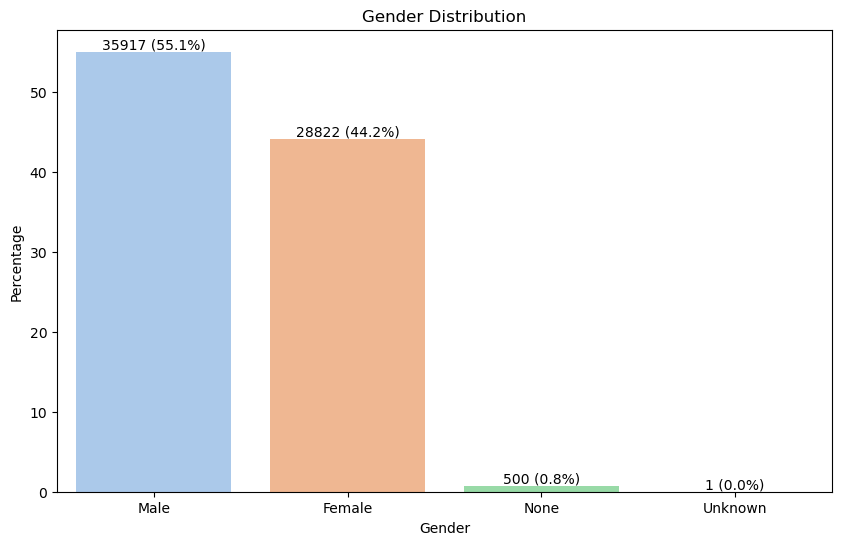

In [129]:
data_by_patient['Sex'].replace({None: 'None'}, inplace=True)

counts = data_by_patient['Sex'].value_counts(dropna=False)  # Includes 'None' values

total = data_by_patient['Sex'].size  # Total count, including 'None'
percentages = (counts / total) * 100

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=percentages.index, y=percentages.values, palette="pastel")
plt.ylabel('Percentage')

for bar, count in zip(bars.patches, counts.values):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height()
    text = f'{count} ({text_y:.1f}%)'
    bars.text(text_x, text_y, text, ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.show()


In [130]:
bins = [0,10,20,30,40,50,60,70,80,90,110]
labels = ['0-9', '10-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
data_by_patient['AgeGroup'] = pd.cut(data_by_patient['Age'], bins=bins, labels=labels, right=False)

In [131]:
age = data_by_patient.groupby(["AgeGroup"]).size().reset_index()
age = age.rename(columns={0: "Count"})
age["Percentage"] = (age['Count'] / age['Count'].sum()) * 100
age

,AgeGroup,Count,Percentage
0,0-9,3,0.004634
1,10-19,697,1.076614
2,20-29,4285,6.618783
3,30-39,5012,7.741736
4,40-49,7709,11.907631
5,50-59,11865,18.327155
6,60-69,12815,19.794563
7,70-79,10995,16.983318
8,80-89,8926,13.787458
9,90+,2433,3.758109


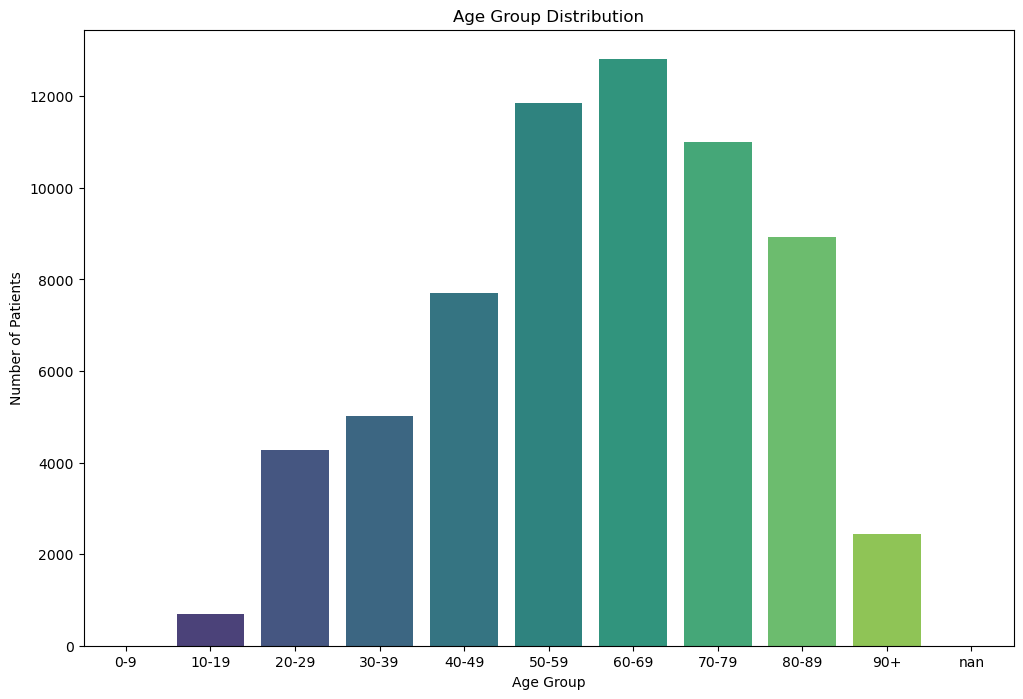

In [138]:
plt.figure(figsize=(12, 8))

age_group_order = data_by_patient['AgeGroup'].sort_values().unique()
sns.countplot(data=data_by_patient, x='AgeGroup', order=age_group_order, palette='viridis')

plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')

plt.show()


<Axes: xlabel='AgeGroup'>

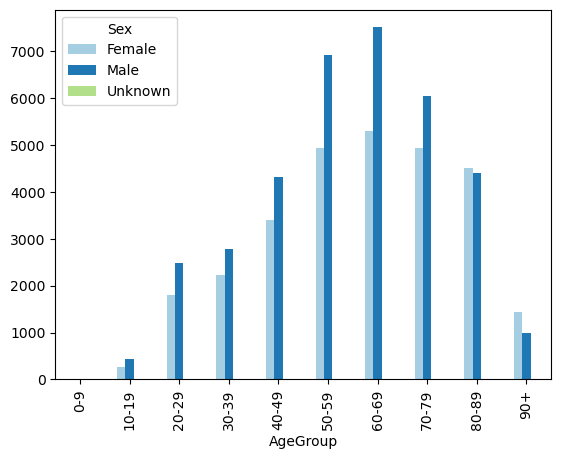

In [140]:
pd.crosstab(data_by_patient['AgeGroup'],data_by_patient['Sex']).plot.bar()

### In depth: 'Frontal/Lateral'

In [58]:
view_counts = data['Frontal/Lateral'].value_counts(dropna=False)
view_percentages = view_counts / len(data) * 100

view_df = pd.DataFrame({
    'Counts': view_counts,
    'Percentages': view_percentages
}).rename(columns={'index': 'Frontal/Lateral'})

view_df['Percentages'] = view_df['Percentages'].apply(lambda x: f"{x:.2f}%")

display(view_df)

,Counts,Percentages
Frontal,191229,85.25%
Lateral,32419,14.45%
NaN,668,0.30%


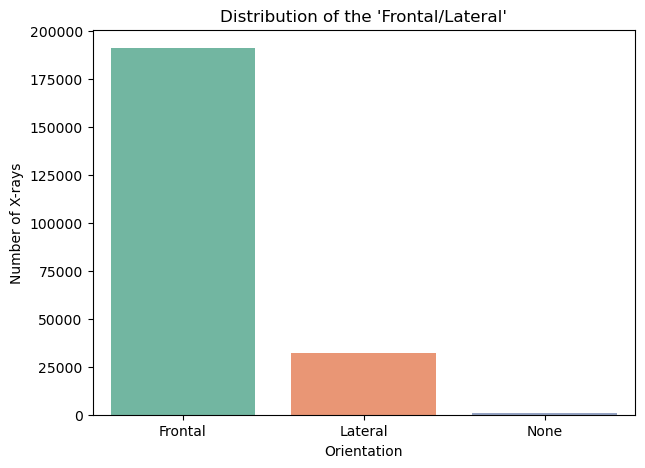

In [157]:
data['Frontal/Lateral'].fillna('None', inplace=True)

orientation_counts = data['Frontal/Lateral'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set2')
plt.title("Distribution of the 'Frontal/Lateral' column")
plt.xlabel('Orientation')
plt.ylabel('Number of X-rays')
plt.show()

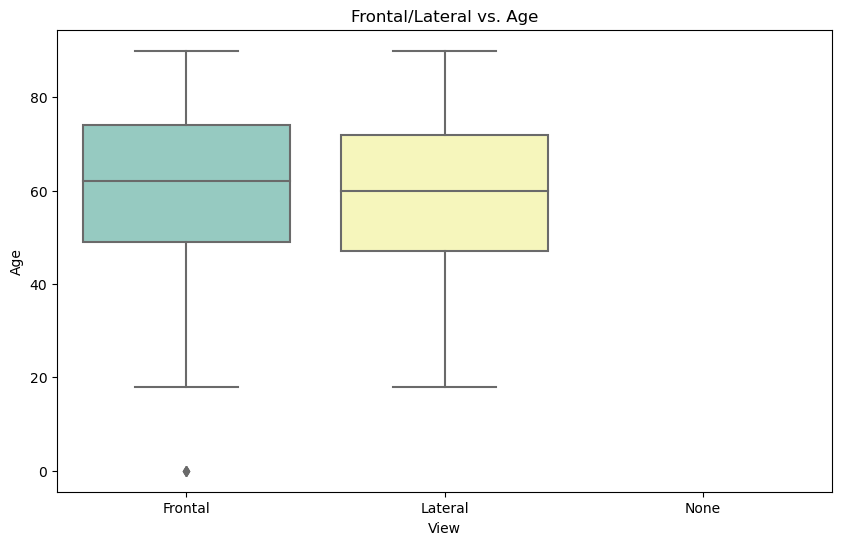

In [161]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Frontal/Lateral', y='Age', data=data, palette='Set3')
plt.title('Frontal/Lateral vs. Age')
plt.xlabel('View')
plt.ylabel('Age')
plt.show()

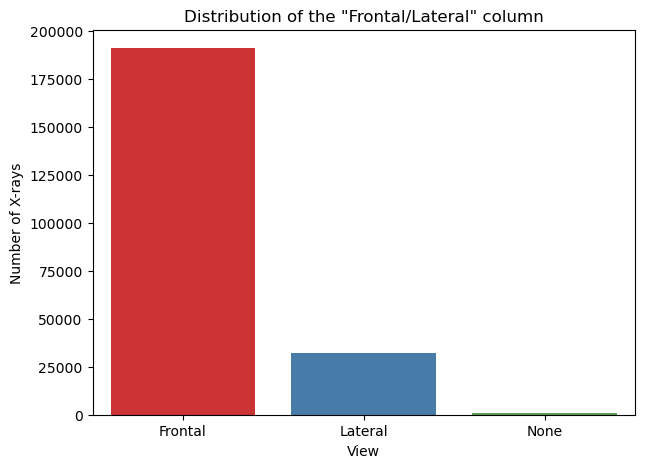

In [169]:
data['Frontal/Lateral'].fillna('None', inplace=True)

orientation_counts = data['Frontal/Lateral'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set1')
plt.title('Distribution of the "Frontal/Lateral" column')
plt.xlabel('View')
plt.ylabel('Number of X-rays')
plt.show()

### In depth: 'AP/PA'

The "AP/PA" column indicates the orientation of the X-ray beam relative to the patient's body:
* **AP (Anteroposterior):** X-ray beam enters the front of the chest and exits the back. Commonly used when patients cannot stand.

* **PA (Posteroanterior):** X-ray beam enters the back of the chest and exits the front. This is the standard chest X-ray view, preferred for diagnostic accuracy.

* **LL (Left Lateral):** In a left lateral view, the patient's left side is closest to the X-ray plate, and the X-ray beam travels from the patient's right side to their left side.

* **RL (Right Lateral):** Conversely, in a right lateral view, the patient's right side is closest to the X-ray plate, with the X-ray beam passing from the patient's left side to their right side.

In [147]:
orientation_counts = data['AP/PA'].value_counts(dropna=False)
orientation_percentages = orientation_counts / len(data) * 100

orientation_df = pd.DataFrame({
    'Counts': orientation_counts,
    'Percentages': orientation_percentages
}).rename(columns={'index': 'AP/PA'})

orientation_df['Percentages'] = orientation_df['Percentages'].apply(lambda x: f"{x:.2f}%")

display(orientation_df)


,Counts,Percentages
AP,161759,72.11%
NaN,33087,14.75%
PA,29453,13.13%
LL,16,0.01%
RL,1,0.00%


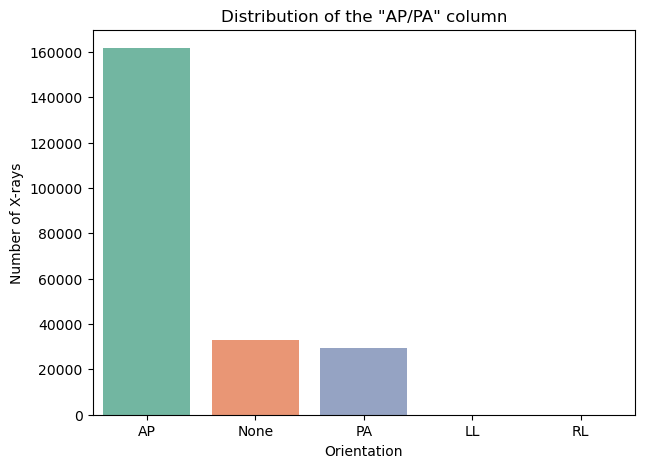

In [165]:
data['AP/PA'].fillna('None', inplace=True)

orientation_counts = data['AP/PA'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set2')
plt.title('Distribution of the "AP/PA" column')
plt.xlabel('Orientation')
plt.ylabel('Number of X-rays')
plt.show()

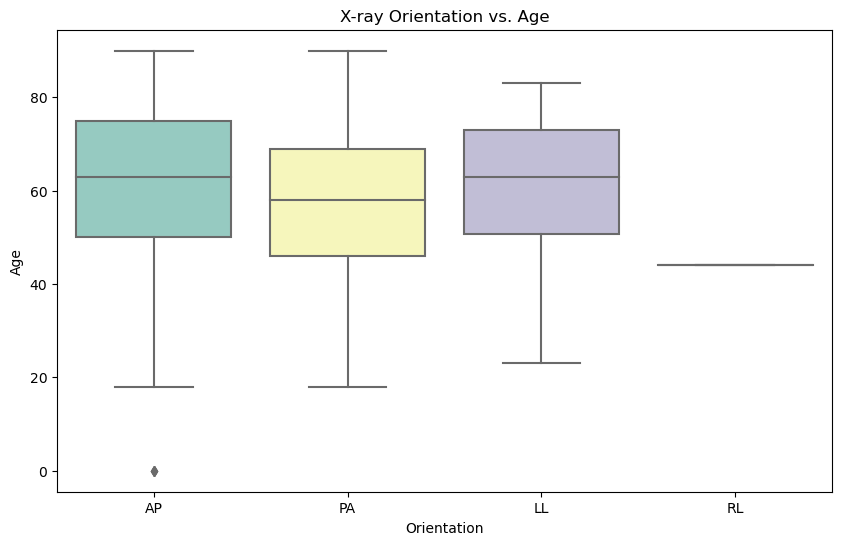

In [142]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='AP/PA', y='Age', data=data, palette='Set3')
plt.title('AP/PA vs. Age')
plt.xlabel('Orientation')
plt.ylabel('Age')
plt.show()

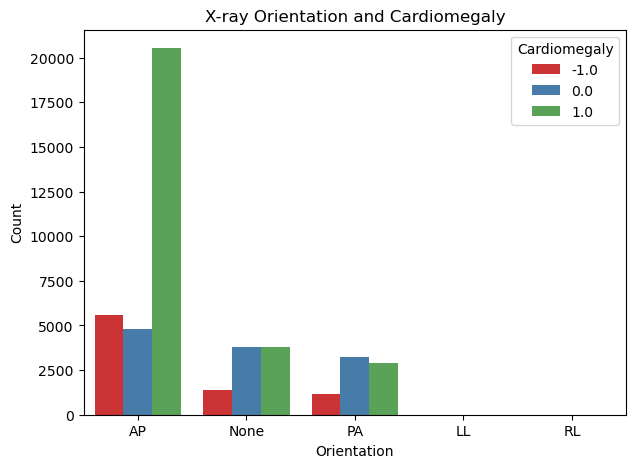

In [167]:
plt.figure(figsize=(7, 5))
sns.countplot(x='AP/PA', hue='Cardiomegaly', data=data, palette='Set1')
plt.title('X-ray Orientation and Cardiomegaly')
plt.xlabel('Orientation')
plt.ylabel('Count')
plt.legend(title='Cardiomegaly', loc='upper right')
plt.show()

## Relationship between variables

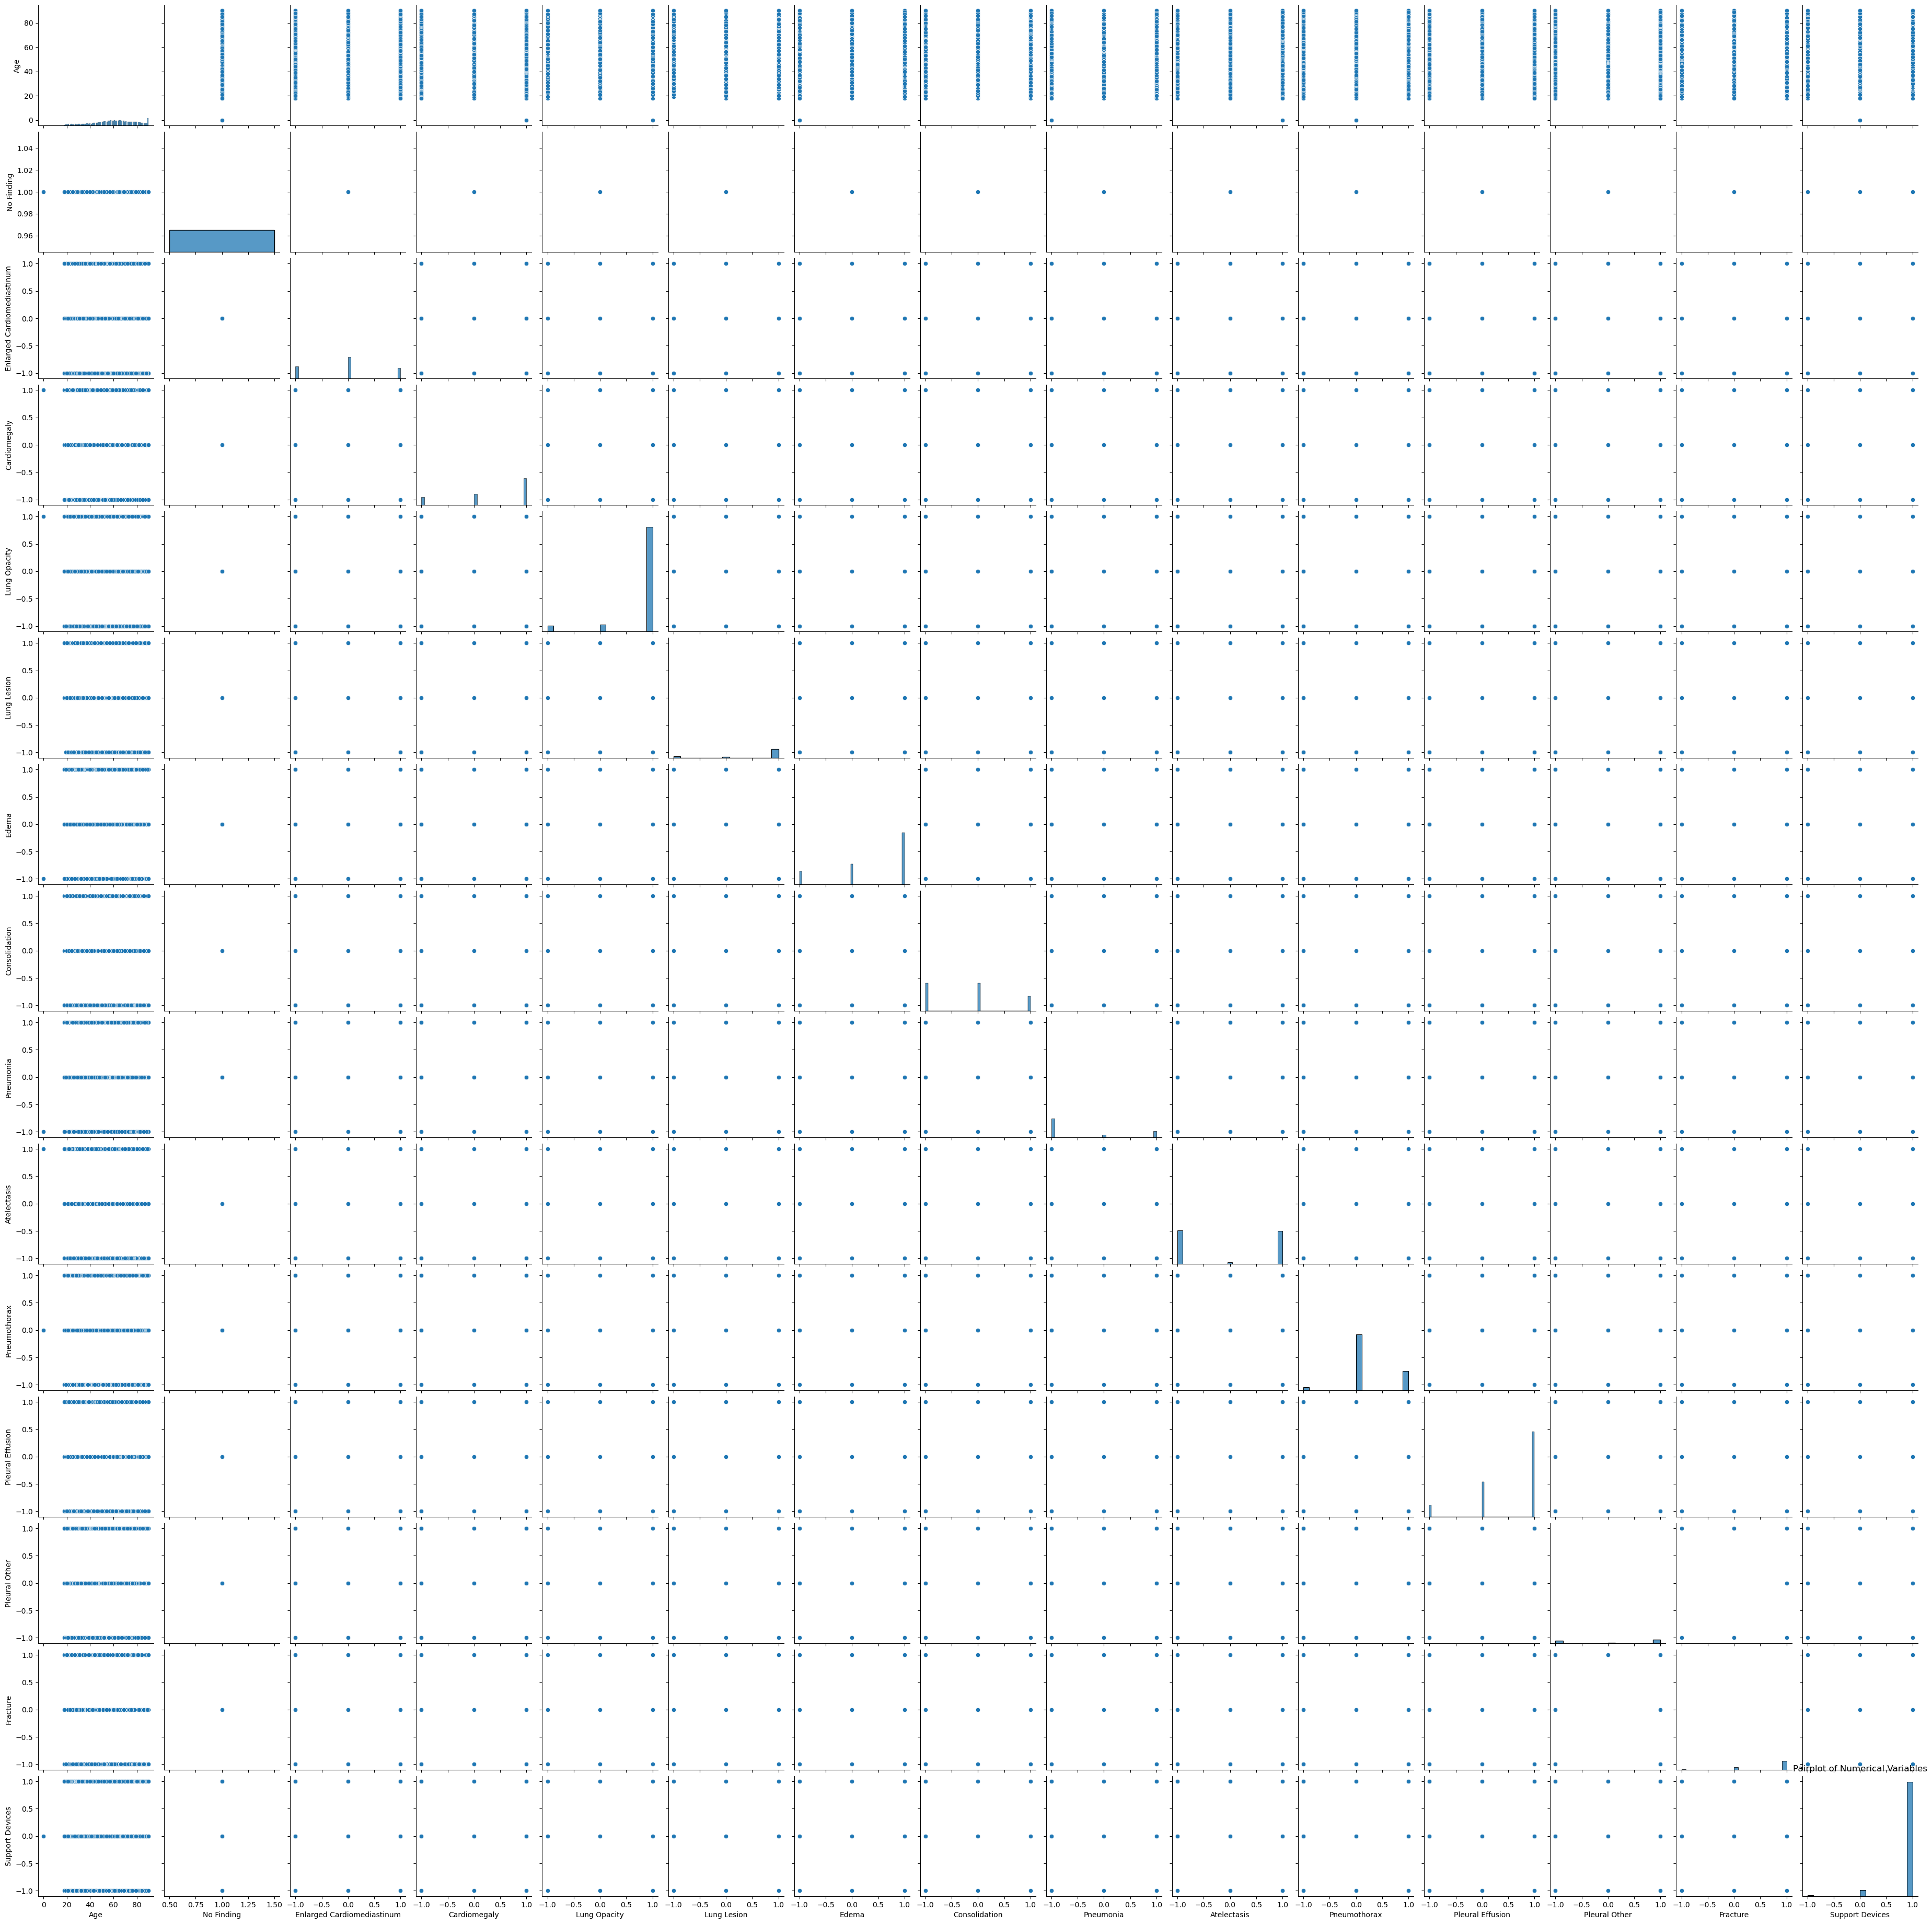

In [21]:
##trying to find potential connections tal vez... or correlation matrix!!

sns.pairplot(numerical_data)
plt.title('Pairplot of Numerical Variables')
plt.show()

The correlation matrix:


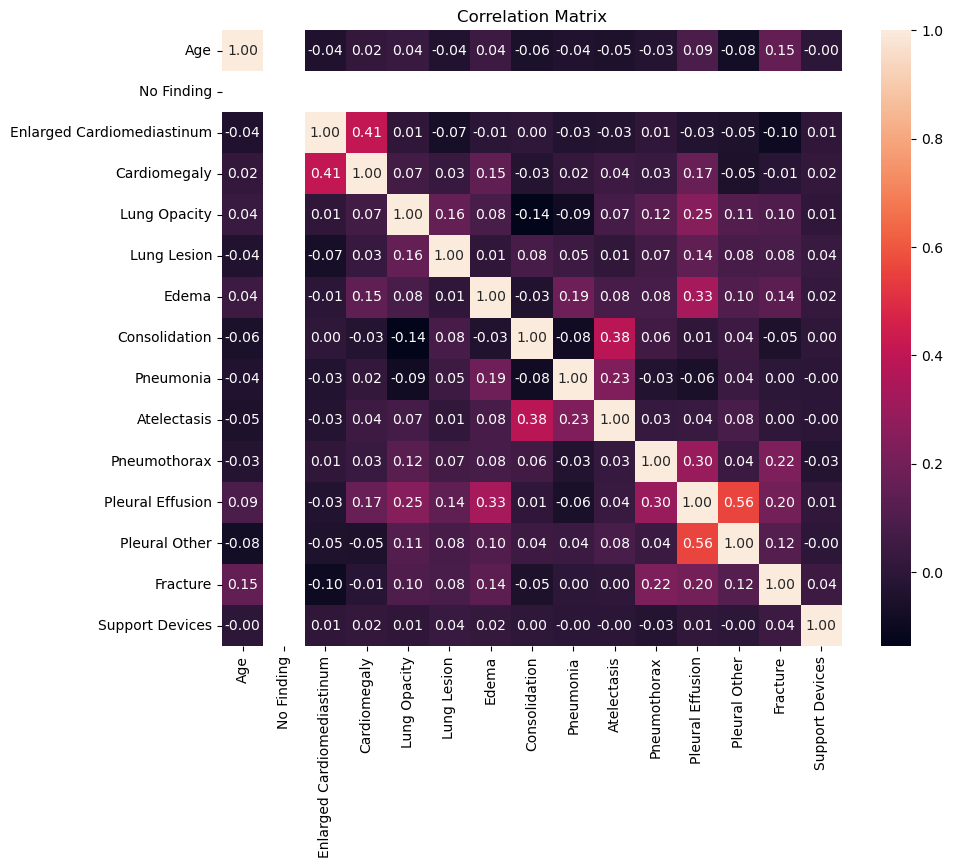

In [22]:
print("The correlation matrix:")

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### **5.  Patterns or anomalies**

- Look for outliers, unusual observations, or patterns in your data through plots and statistical summaries.
- Investigate any anomalies to understand their cause — they could be data entry errors, exceptional cases, or important discoveries.

## Visualizing the chest X-rays


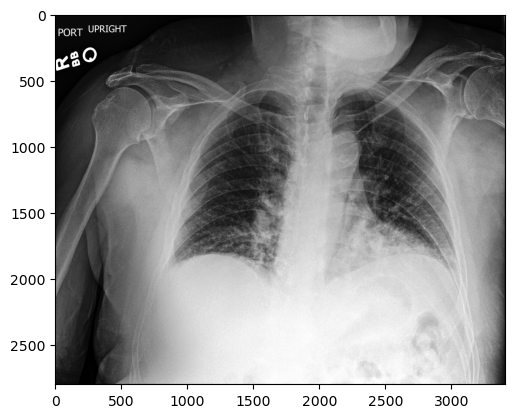

In [23]:
img_id = "view1_frontal.jpg"
img_dir = "patient64813/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

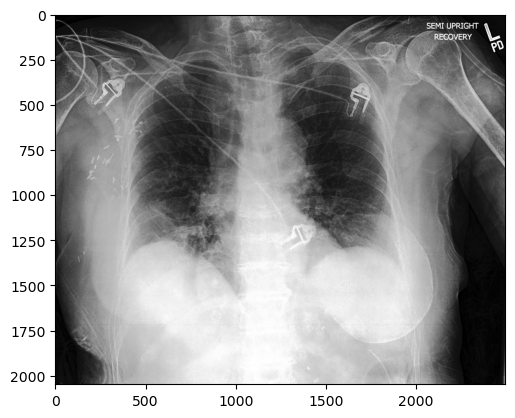

In [24]:
img_id = "view1_frontal.jpg"
img_dir = "patient64742/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

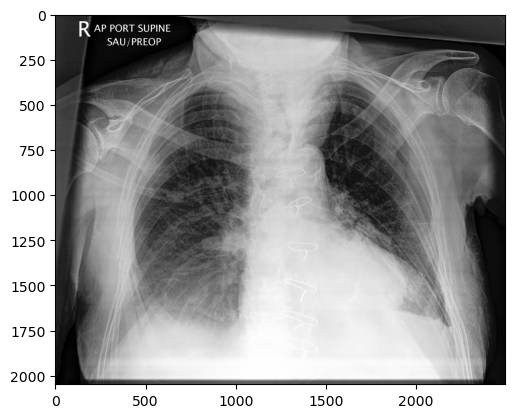

In [25]:
img_id = "view1_frontal.jpg"
img_dir = "patient64743/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

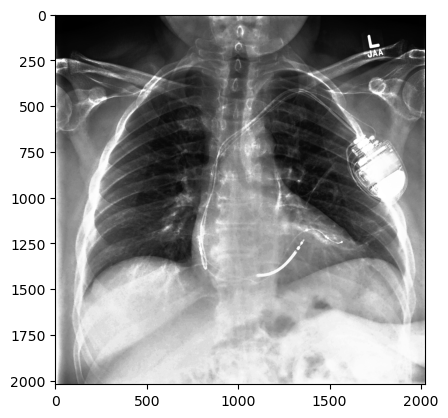

In [26]:
img_id = "view1_frontal.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

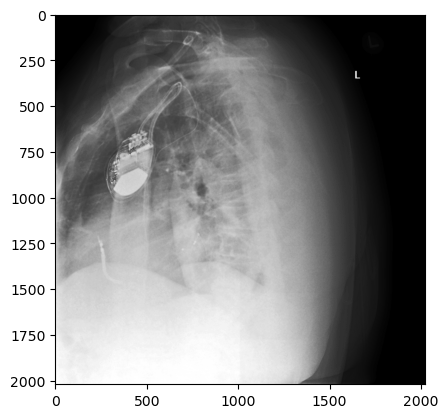

In [27]:
img_id = "view2_lateral.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

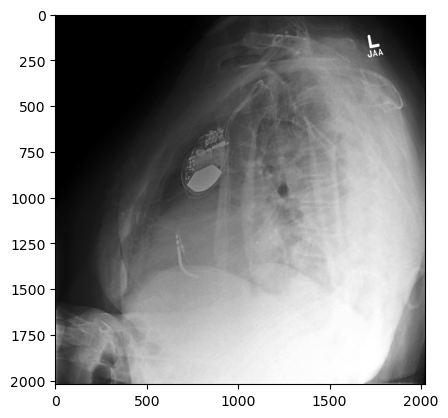

In [28]:
img_id = "view3_lateral.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

## Random, Balanced, Biased Data Splits

### Train Data

In [6]:
original_data = train_data

sex_distribution_counts = original_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = original_data['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = original_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = original_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 132636 (59.37%)
Female: 90777 (40.63%)
Unknown: 1 (0.00%)

Pneumothorax Distribution:
nan: 144480 (64.67%)
0.0: 56341 (25.22%)
1.0: 19448 (8.70%)
-1.0: 3145 (1.41%)


### Random

In [7]:
random_data_train = pd.read_csv("../shortcuts-chest-xray/random_dataset_train.csv", index_col=0)

sex_distribution_counts = random_data_train['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_data_train['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = random_data_train['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_data_train['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 9005 (57.18%)
Female: 6744 (42.82%)

Pneumothorax Distribution:
nan: 9991 (63.44%)
0.0: 4251 (26.99%)
1.0: 1293 (8.21%)
-1.0: 214 (1.36%)


In [8]:
random_data_val = pd.read_csv("../shortcuts-chest-xray/random_dataset_train.csv", index_col=0)

sex_distribution_counts = random_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = random_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 9005 (57.18%)
Female: 6744 (42.82%)

Pneumothorax Distribution:
nan: 9991 (63.44%)
0.0: 4251 (26.99%)
1.0: 1293 (8.21%)
-1.0: 214 (1.36%)


In [9]:
random_data_test = pd.read_csv("../shortcuts-chest-xray/random_dataset_test.csv", index_col=0)

sex_distribution_counts = random_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = random_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 2307 (59.97%)
Female: 1540 (40.03%)

Pneumothorax Distribution:
nan: 2440 (63.43%)
0.0: 1010 (26.25%)
1.0: 345 (8.97%)
-1.0: 52 (1.35%)


### Balanced data

In [3]:
balanced_data_train = pd.read_csv("../shortcuts-chest-xray/balanced_dataset_train.csv", index_col=0)

sex_distribution_counts = balanced_data_train['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_data_train['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = balanced_data_train['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_data_train['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 10552 (51.18%)
Female: 10066 (48.82%)

Pneumothorax Distribution:
1.0: 10198 (49.46%)
nan: 7407 (35.92%)
0.0: 2840 (13.77%)
-1.0: 173 (0.84%)


In [8]:
pneumothorax_by_sex_distribution = balanced_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=False, dropna=False)
pneumothorax_by_sex_percentage = balanced_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("Pneumothorax Distribution within Each Gender:\n")
for (sex, pneumothorax), count in pneumothorax_by_sex_distribution.items():
    percentage = pneumothorax_by_sex_percentage[(sex, pneumothorax)]
    print(f"{sex}, Pneumothorax={pneumothorax}: {count} ({percentage:.2f}%)")

Pneumothorax Distribution within Each Gender:

Female, Pneumothorax=1.0: 4868 (48.36%)
Female, Pneumothorax=nan: 3750 (37.25%)
Female, Pneumothorax=0.0: 1369 (13.60%)
Female, Pneumothorax=-1.0: 79 (0.78%)
Male, Pneumothorax=1.0: 5330 (50.51%)
Male, Pneumothorax=nan: 3657 (34.66%)
Male, Pneumothorax=0.0: 1471 (13.94%)
Male, Pneumothorax=-1.0: 94 (0.89%)


In [4]:
balanced_data_val = pd.read_csv("../shortcuts-chest-xray/balanced_dataset_val.csv", index_col=0)

sex_distribution_counts = balanced_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = balanced_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Female: 2239 (50.29%)
Male: 2213 (49.71%)

Pneumothorax Distribution:
1.0: 2166 (48.65%)
nan: 1626 (36.52%)
0.0: 613 (13.77%)
-1.0: 47 (1.06%)


In [5]:
balanced_data_test = pd.read_csv("../shortcuts-chest-xray/balanced_dataset_test.csv", index_col=0)

sex_distribution_counts = balanced_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = balanced_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 2235 (51.10%)
Female: 2139 (48.90%)

Pneumothorax Distribution:
1.0: 2080 (47.55%)
nan: 1631 (37.29%)
0.0: 638 (14.59%)
-1.0: 25 (0.57%)


### Biased

In [10]:
biased_data_train = pd.read_csv("../shortcuts-chest-xray/biased_dataset_train.csv", index_col=0)

sex_distribution_counts = biased_data_train['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_train['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_train['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_train['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 16184 (79.75%)
Female: 4110 (20.25%)

Pneumothorax Distribution:
1.0: 9766 (48.12%)
nan: 7449 (36.71%)
0.0: 2894 (14.26%)
-1.0: 185 (0.91%)


In [11]:
pneumothorax_by_sex_distribution = biased_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=False, dropna=False)
pneumothorax_by_sex_percentage = biased_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("Pneumothorax Distribution within Each Gender:\n")
for (sex, pneumothorax), count in pneumothorax_by_sex_distribution.items():
    percentage = pneumothorax_by_sex_percentage[(sex, pneumothorax)]
    print(f"{sex}, Pneumothorax={pneumothorax}: {count} ({percentage:.2f}%)")

Pneumothorax Distribution within Each Gender:

Female, Pneumothorax=1.0: 2046 (49.78%)
Female, Pneumothorax=nan: 1493 (36.33%)
Female, Pneumothorax=0.0: 538 (13.09%)
Female, Pneumothorax=-1.0: 33 (0.80%)
Male, Pneumothorax=1.0: 7720 (47.70%)
Male, Pneumothorax=nan: 5956 (36.80%)
Male, Pneumothorax=0.0: 2356 (14.56%)
Male, Pneumothorax=-1.0: 152 (0.94%)


In [12]:
biased_data_val = pd.read_csv("../shortcuts-chest-xray/biased_dataset_val.csv", index_col=0)

sex_distribution_counts = biased_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 3317 (78.23%)
Female: 923 (21.77%)

Pneumothorax Distribution:
1.0: 2002 (47.22%)
nan: 1582 (37.31%)
0.0: 620 (14.62%)
-1.0: 36 (0.85%)


In [13]:
biased_data_test = pd.read_csv("../shortcuts-chest-xray/biased_dataset_test.csv", index_col=0)

sex_distribution_counts = biased_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 3248 (77.06%)
Female: 967 (22.94%)

Pneumothorax Distribution:
1.0: 1981 (47.00%)
nan: 1610 (38.20%)
0.0: 601 (14.26%)
-1.0: 23 (0.55%)


### Chest Drains

In [20]:
import pandas as pd
drains_376 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/drains_376.csv")

drain_counts = drains_376['Drain'].value_counts(dropna=False)
pneumothorax_counts = drains_376['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 1    376
Name: Drain, dtype: int64 

Pneumothorax:
 1    304
0     72
Name: Pneumothorax, dtype: int64


In [21]:
thorax_negative_300 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/thorax_negative_300.csv")

drain_counts = thorax_negative_300['Drain'].value_counts(dropna=False)
pneumothorax_counts = thorax_negative_300['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    300
Name: Drain, dtype: int64 

Pneumothorax:
 0    300
Name: Pneumothorax, dtype: int64


In [22]:
thorax_positive_300 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/thorax_positive_300.csv")

drain_counts = thorax_positive_300['Drain'].value_counts(dropna=False)
pneumothorax_counts = thorax_positive_300['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    300
Name: Drain, dtype: int64 

Pneumothorax:
 1    300
Name: Pneumothorax, dtype: int64


In [29]:
chest_drains = pd.concat([drains_376, thorax_negative_300, thorax_positive_300])

drain_counts = chest_drains['Drain'].value_counts(dropna=False)
pneumothorax_counts = chest_drains['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    600
1    376
Name: Drain, dtype: int64 

Pneumothorax:
 1    604
0    372
Name: Pneumothorax, dtype: int64


In [34]:
# chest_drains.to_csv('../shortcuts-chest-xray/chest_drains_dataset.csv', index=False)

#### Train/val/test

In [38]:
chest_drains_data_train = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_train.csv", index_col=0)

drains_distribution_counts = chest_drains_data_train['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_train['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_train['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_train['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
0: 429 (65.60%)
1: 225 (34.40%)

Pneumothorax Distribution:
1: 393 (60.09%)
0: 261 (39.91%)


In [39]:
chest_drains_data_val = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_val.csv", index_col=0)

drains_distribution_counts = chest_drains_data_val['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_val['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
1: 108 (54.82%)
0: 89 (45.18%)

Pneumothorax Distribution:
1: 141 (71.57%)
0: 56 (28.43%)


In [40]:
chest_drains_data_test = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_test.csv", index_col=0)

drains_distribution_counts = chest_drains_data_test['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_test['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
0: 82 (65.60%)
1: 43 (34.40%)

Pneumothorax Distribution:
1: 70 (56.00%)
0: 55 (44.00%)


### UFES

In [5]:
pad_ufes = pd.read_csv("../../../data_shares/purrlab/PAD-UFES-20/metadata.csv")
pad_ufes

### NIH

In [7]:
data_entry = pd.read_csv("../../../data_shares/purrlab_students/ChestX-ray14/Data_Entry_2017.csv")
data_entry['Pneumothorax'] = data_entry['Finding Labels'].str.contains('Pneumothorax').astype(int)
# data_entry

In [25]:
pneumothorax_counts = data_entry['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
 0    106818
1      5302
Name: Pneumothorax, dtype: int64


In [3]:
import pandas as pd

drain_annotations = pd.read_csv('../shortcuts-chest-xray/preprocess/NIH-CX14_TubeAnnotations_NonExperts_aggregated.csv')
# drain_annotations

drain_counts = drain_annotations['Drain'].value_counts(dropna=False)

print("Drains:\n", drain_counts)

Drains:
 0    1906
1    1637
Name: Drain, dtype: int64


In [30]:
drain_counts = drain_annotations['Drain'].value_counts(dropna=False)

print("Drains:\n", drain_counts)

Drains:
 0    1906
1    1637
Name: Drain, dtype: int64


In [11]:
chest_drains = pd.read_csv('../shortcuts-chest-xray/chest_drains_df.csv')
chest_drains

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Drain,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,NaN,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,NaN,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,NaN,0
3,00000002_000.png,No Finding,0,2,81,M,PA,NaN,0
4,00000003_000.png,Hernia,0,3,81,F,PA,NaN,0
...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,NaN,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,NaN,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,NaN,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,NaN,0


In [13]:
pneumothorax_counts = chest_drains['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
 0    106818
1      5302
Name: Pneumothorax, dtype: int64


In [6]:
import pandas as pd
predictions = pd.read_csv('../shortcuts-chest-xray/predictions/Pred_Balanced_Sex_0_0.csv')
pneumothorax_counts = predictions['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
  1.0    2080
 NaN    1631
 0.0     638
-1.0      25
Name: Pneumothorax, dtype: int64


In [3]:
import pandas as pd
drains = pd.read_csv('../shortcuts-chest-xray/preprocess/datasets/chest_drains_dataset_train.csv')

pneumothorax_counts = drains['Pneumothorax'].value_counts(dropna=False)
print("Pneumothorax:\n", pneumothorax_counts)

drain_counts = drains['Drain'].value_counts(dropna=False)
print("Drains:\n", drain_counts)

Pneumothorax:
 0    3363
1    2548
Name: Pneumothorax, dtype: int64
Drains:
 0    4420
1    1491
Name: Drain, dtype: int64
